# Questions

1. What are my most-played games?

2. What genres do I spend the most time on?

3. Which games gave me the best value for money?

4. What does my backlog look like?

5. How is my playtime distributed across my library between my top 5 games and remaining games?


In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# API key and Steam ID
api_key = "3DBDD6E1E5199990245EE53E02092FF9"
steam_id = "76561198379709698"

In [4]:
# Fetch owned games data from Steam API
url = f"http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={api_key}&steamid={steam_id}&include_appinfo=1&include_played_free_games=1&format=json"

response = requests.get(url)
data = response.json()

games = data['response']['games']
df = pd.DataFrame(games)

df.head(5)

,appid,name,playtime_forever,img_icon_url,has_community_visible_stats,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,playtime_deck_forever,rtime_last_played,playtime_disconnected,content_descriptorids,has_leaderboards
0,4000,Garry's Mod,90,4a6f25cfa2426445d0d9d6e233408de4d371ce8b,True,0,0,0,0,1551326096,0,NaN,NaN
1,550,Left 4 Dead 2,16,7d5a243f9500d2f8467312822f8af2a2928777ed,True,0,0,0,0,1514671303,0,"[2, 5]",NaN
2,105600,Terraria,312,858961e95fbf869f136e1770d586e0caefd4cfac,True,0,0,0,0,1497317819,0,NaN,NaN
3,236390,War Thunder,63,c69fbafb6e9891314cc5df0fe6a659612c289bf9,True,0,0,0,0,1525587428,0,NaN,NaN
4,223710,Cry of Fear,10,962637bf69fddc5466b042c748b6408d2901f25c,NaN,10,0,0,0,1748487564,0,NaN,NaN


In [5]:
# Data cleaning and transformation
# Convert playtime from minutes to hours and format last played time
df['playtime_forever'] = round(df['playtime_forever'] / 60,2)
df['rtime_last_played'] = pd.to_datetime(df['rtime_last_played'], unit = 's')
df.sort_values(by = 'playtime_forever', ascending = False, inplace = True)

In [6]:
# Rename columns for clarity
df.rename(columns = {'playtime_forever': 'playtime_overall_hours'}, inplace = True)
df.head(5)

,appid,name,playtime_overall_hours,img_icon_url,has_community_visible_stats,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,playtime_deck_forever,rtime_last_played,playtime_disconnected,content_descriptorids,has_leaderboards
6,252490,Rust,5798.03,820be4782639f9c4b64fa3ca7e6c26a95ae4fd1c,True,201495,0,0,0,2025-03-25 03:58:11,6,"[1, 2, 5]",NaN
9,271590,Grand Theft Auto V Legacy,583.60,1e72f87eb927fa1485e68aefaff23c7fd7178251,True,30303,0,0,0,2025-03-22 21:10:47,0,[5],NaN
12,730,Counter-Strike 2,421.90,8dbc71957312bbd3baea65848b545be9eae2a355,True,15332,0,0,0,2025-08-14 02:30:43,0,"[2, 5]",NaN
15,346110,ARK: Survival Evolved,377.30,fef1799533131c10f538d2dd697bbbd89e663265,True,14174,0,0,0,2025-07-12 00:25:11,20,NaN,NaN
81,2767030,Marvel Rivals,300.15,839b4712925b95702ca56e0c4d399adf54f4d617,True,18009,0,0,0,2025-05-29 04:39:11,1,NaN,NaN


In [7]:
# Subset and sort data for top 15 games by playtime
df_subset = df[['appid', 'name', 'playtime_overall_hours', 'rtime_last_played']].sort_values(by = 'playtime_overall_hours', ascending = False)
df_subset_top = df_subset.head(15)

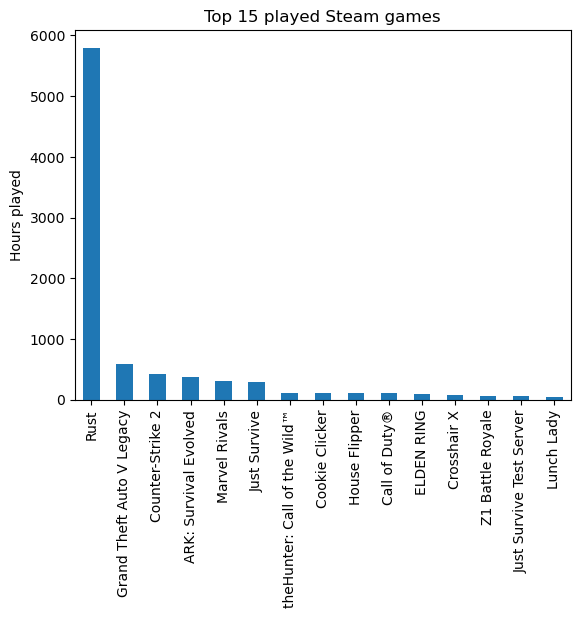

In [8]:
# Visualization of top 15 games by playtime
df_subset_top.plot(kind = 'bar', x = 'name', y = 'playtime_overall_hours', title = 'Top 15 played Steam games', xlabel = '', ylabel = 'Hours played', legend = False)
plt.show()

In [9]:
# Fetch additional store information for each game
import time

store_info_list = []

headers = {'User-Agent': 'Mozilla/5.0'}
# Loop through each appid to get store details
for app_id in df_subset['appid']:
    url_2 = f"https://store.steampowered.com/api/appdetails?appids={app_id}&cc=us&l=en"
    try:
        response_2 = requests.get(url_2, headers=headers, timeout=5)
        response_2.raise_for_status()
        data_2 = response_2.json()
    except (requests.exceptions.RequestException, ValueError) as e:
        print(f'Failed for appid {app_id}: {e}')
        store_info_list.append({
            'appid': app_id,
            'price_cents': None,
            'currency': None,
            'release_date': None,
            'genres': None
        })
        continue
# Extract relevant information if available
    if str(app_id) in data_2 and data_2[str(app_id)]['success']:
        info = data_2[str(app_id)]['data']
        price = info.get('price_overview', {}).get('final', None)
        currency = info.get('price_overview', {}).get('currency', None)
        release_date = info.get('release_date', {}).get('date', None)
        genres = ', '.join([g['description'] for g in info.get('genres', [])])
        
        store_info_list.append({
            'appid': app_id,
            'price_cents': price,
            'currency': currency,
            'release_date': release_date,
            'genres': genres
        })
    else:
        store_info_list.append({
            'appid': app_id,
            'price_cents': None,
            'currency': None,
            'release_date': None,
            'genres': None
        })

    time.sleep(0.2)
# Merge store information with the original dataframe
df_store = pd.DataFrame(store_info_list)

df_merged = df_subset.merge(df_store, on='appid', how='left')

df_merged['price_dollars'] = df_merged['price_cents'] / 100

df_merged.head(5)
    

,appid,name,playtime_overall_hours,rtime_last_played,price_cents,currency,release_date,genres,price_dollars
0,252490,Rust,5798.03,2025-03-25 03:58:11,3999.0,USD,"Feb 8, 2018","Action, Adventure, Indie, Massively Multiplaye...",39.99
1,271590,Grand Theft Auto V Legacy,583.60,2025-03-22 21:10:47,NaN,None,"Apr 13, 2015","Action, Adventure",NaN
2,730,Counter-Strike 2,421.90,2025-08-14 02:30:43,NaN,None,"Aug 21, 2012","Action, Free To Play",NaN
3,346110,ARK: Survival Evolved,377.30,2025-07-12 00:25:11,1499.0,USD,"Aug 27, 2017","Action, Adventure, Indie, Massively Multiplaye...",14.99
4,2767030,Marvel Rivals,300.15,2025-05-29 04:39:11,NaN,None,"Dec 5, 2024","Action, Free To Play",NaN


In [10]:
# Correct known data inaccuracies
df_merged.loc[df_merged['name'] == "Grand Theft Auto V Legacy", 'price_cents'] = 5999.0
df_merged.loc[df_merged['name'] == "Grand Theft Auto V Legacy", 'price_dollars'] = 59.99

df_merged.head()

,appid,name,playtime_overall_hours,rtime_last_played,price_cents,currency,release_date,genres,price_dollars
0,252490,Rust,5798.03,2025-03-25 03:58:11,3999.0,USD,"Feb 8, 2018","Action, Adventure, Indie, Massively Multiplaye...",39.99
1,271590,Grand Theft Auto V Legacy,583.60,2025-03-22 21:10:47,5999.0,None,"Apr 13, 2015","Action, Adventure",59.99
2,730,Counter-Strike 2,421.90,2025-08-14 02:30:43,NaN,None,"Aug 21, 2012","Action, Free To Play",NaN
3,346110,ARK: Survival Evolved,377.30,2025-07-12 00:25:11,1499.0,USD,"Aug 27, 2017","Action, Adventure, Indie, Massively Multiplaye...",14.99
4,2767030,Marvel Rivals,300.15,2025-05-29 04:39:11,NaN,None,"Dec 5, 2024","Action, Free To Play",NaN


In [11]:
# Handle missing values
df_merged.fillna({'price_cents': 0, 'price_dollars': 0}, inplace = True)
df_merged['currency'].fillna('USD', inplace = True)

df_merged.sample(5)

C:\Users\smith\AppData\Local\Temp\ipykernel_27440\404391952.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['currency'].fillna('USD', inplace = True)


,appid,name,playtime_overall_hours,rtime_last_played,price_cents,currency,release_date,genres,price_dollars
17,1966720,Lethal Company,34.23,2024-07-14 03:52:47,999.0,USD,"Oct 23, 2023","Action, Adventure, Indie, Early Access",9.99
55,2551020,One-armed robber,2.02,2024-05-03 04:16:53,0.0,USD,"Dec 15, 2023","Action, Indie, Simulation, Strategy, Free To Play",0.00
86,1085510,Garfield Kart - Furious Racing,0.00,1970-01-01 00:00:00,1499.0,USD,"Nov 6, 2019",Racing,14.99
34,886250,Vegas Infinite by PokerStars,10.90,2024-12-14 10:31:51,0.0,USD,"Nov 10, 2023","Casual, Strategy, Free To Play",0.00
40,1302240,Labyrinthine,8.12,2024-10-28 06:20:35,999.0,USD,"Aug 18, 2023","Action, Adventure, Indie",9.99


In [12]:
# Genre analysis
#Splitting genres into separate rows for analysis
df_merged['genres_split'] = df_merged['genres'].str.split(', ')
genres_sep = df_merged.explode('genres_split')
df_merged['genres_split'] = df_merged['genres'].str.strip()

genres_sep = genres_sep[genres_sep['genres_split'] != '']
counts = genres_sep['genres_split'].value_counts()




<Axes: title={'center': 'Genres Played Distribution'}, xlabel='Genres'>

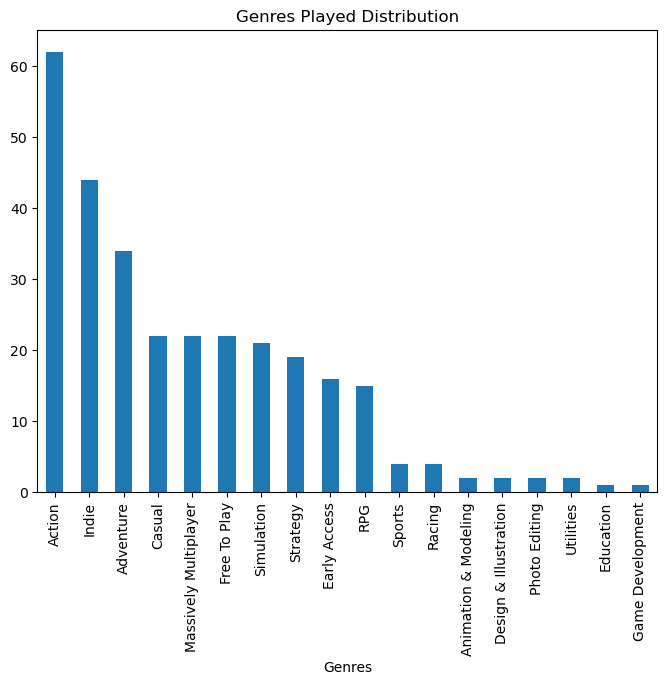

In [13]:
counts.plot(kind = 'bar', title = 'Genres Played Distribution', xlabel = 'Genres', figsize = (8, 6))

In [14]:
# Calculate game value metric and sort
df_merged['game_value'] = df_merged['playtime_overall_hours'] / df_merged['price_dollars']
df_merged.sort_values(by = 'game_value', ascending = False, inplace = True)

df_merged['game_value'].replace(np.nan, 'Never Played', inplace = True)
df_merged['game_value'].replace(np.inf, 0.0, inplace = True)

df_merged_plot = df_merged[df_merged['game_value'] != 'Never Played']
df_merged_plot.sort_values(by = 'game_value', ascending = True)
df_merged_plot.head(5)

C:\Users\smith\AppData\Local\Temp\ipykernel_27440\526179675.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['game_value'].replace(np.nan, 'Never Played', inplace = True)


,appid,name,playtime_overall_hours,rtime_last_played,price_cents,currency,release_date,genres,price_dollars,genres_split,game_value
63,236390,War Thunder,1.05,2018-05-06 06:17:08,0.0,USD,"Aug 15, 2013","Action, Massively Multiplayer, Simulation, Fre...",0.0,"Action, Massively Multiplayer, Simulation, Fre...",0.0
74,809960,Radical Heights,0.43,2018-04-18 16:35:41,0.0,USD,"Apr 10, 2018","Action, Adventure, Free To Play, Indie, Massiv...",0.0,"Action, Adventure, Free To Play, Indie, Massiv...",0.0
29,3081410,Battlefield™ 6 Open Beta,14.77,2025-08-16 08:22:25,0.0,USD,"Aug 4, 2025",,0.0,,0.0
34,886250,Vegas Infinite by PokerStars,10.90,2024-12-14 10:31:51,0.0,USD,"Nov 10, 2023","Casual, Strategy, Free To Play",0.0,"Casual, Strategy, Free To Play",0.0
80,1902490,Aperture Desk Job,0.02,2022-09-28 02:02:20,0.0,USD,"Mar 1, 2022","Action, Adventure, Casual, Free To Play",0.0,"Action, Adventure, Casual, Free To Play",0.0


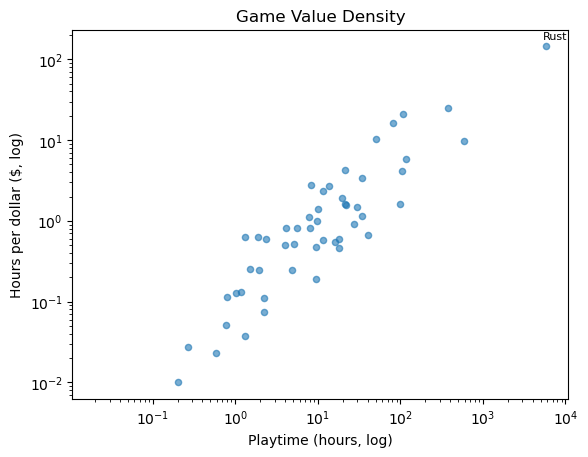

In [15]:
# Visualization of game value
df_merged_plot.plot(kind = 'scatter', x = 'playtime_overall_hours', y = 'game_value', alpha = 0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Playtime (hours, log)")
plt.ylabel("Hours per dollar ($, log)")
plt.title("Game Value Density")

top_game = df_merged_plot.nlargest(1, 'playtime_overall_hours')

for _, row in top_game.iterrows():
    plt.annotate(
        row["name"],
        (row["playtime_overall_hours"], row["game_value"]),
        xytext=(-2,5), textcoords="offset points",
        fontsize=8
    )


In [16]:
money_spent = df_merged[df_merged['playtime_overall_hours'] == 0.0]
print(f'I have spent {money_spent['price_dollars'].sum():.2f} on Steam games I never ended up playing. :C')

I have spent 124.94 on Steam games I never ended up playing. :C


In [ ]:
# Calculate playtime distribution between top 5 games and others
five_most_played = df_merged.nlargest(5, 'playtime_overall_hours')
top_games_playtime = five_most_played['playtime_overall_hours'].sum()
not_top_games = df_merged.drop(five_most_played.index)
not_top_games_playtime = not_top_games['playtime_overall_hours'].sum()
overall_playtime = df_merged['playtime_overall_hours'].sum()

print(f'My top 5 most played games account for {top_games_playtime:.2f} hours, which is %{top_games_playtime / overall_playtime * 100:.2f} of my total platime.')
print(f'My other games account for {not_top_games_playtime:.2f} hours, which is %{not_top_games_playtime / overall_playtime * 100:.2f} of my total platime.')


My top 5 most played games account for 7480.98 hours, which is %82.03 of my total platime.
My other games account for 1638.65 hours, which is %17.97 of my total platime.


([<matplotlib.patches.Wedge at 0x278945af500>,
 [Text(-0.9293457540006218, 0.588486592473453, 'Top 5 Most Played'),
  Text(0.9293458090987089, -0.5884865054618215, 'Other Games')],
 [Text(-0.506915865818521, 0.3209926868037016, '82.03%'),
  Text(0.506915895872023, -0.32099263934281164, '17.97%')])

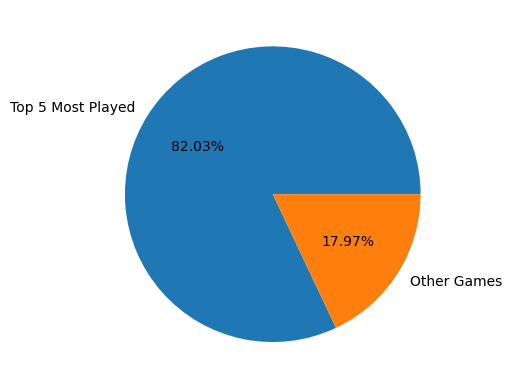

In [ ]:
# Visualization of playtime distribution
labels = ['Top 5 Most Played', 'Other Games']
plt.pie([top_games_playtime, not_top_games_playtime], labels = labels, autopct='%1.2f%%')